In [14]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Hyperparams we are going to tweak through testing

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-03-30 18:52:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.13.240, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-03-30 18:52:33 (289 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [6]:
with open('/tmp/sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])


In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]


In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# convert to numpy

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(training_padded, training_labels, epochs = 30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6683 - acc: 0.5832 - val_loss: 0.6042 - val_acc: 0.6217
Epoch 2/30
625/625 - 2s - loss: 0.4546 - acc: 0.8199 - val_loss: 0.4044 - val_acc: 0.8188
Epoch 3/30
625/625 - 2s - loss: 0.3246 - acc: 0.8701 - val_loss: 0.3604 - val_acc: 0.8472
Epoch 4/30
625/625 - 2s - loss: 0.2705 - acc: 0.8952 - val_loss: 0.3474 - val_acc: 0.8527
Epoch 5/30
625/625 - 2s - loss: 0.2349 - acc: 0.9090 - val_loss: 0.3428 - val_acc: 0.8568
Epoch 6/30
625/625 - 2s - loss: 0.2077 - acc: 0.9207 - val_loss: 0.3442 - val_acc: 0.8539
Epoch 7/30
625/625 - 2s - loss: 0.1840 - acc: 0.9309 - val_loss: 0.3533 - val_acc: 0.8539
Epoch 8/30
625/625 - 2s - loss: 0.1660 - acc: 0.9380 - val_loss: 0.3642 - val_acc: 0.8545
Epoch 9/30
625/625 - 2s - loss: 0.1509 - acc: 0.9456 - val_loss: 0.3785 - val_acc: 0.8532
Epoch 10/30
625/625 - 2s - loss: 0.1361 - acc: 0.9515 - val_loss: 0.3958 - val_acc: 0.8501
Epoch 11/30
625/625 - 2s - loss: 0.1247 - acc: 0.9570 - val_loss: 0.4180 - val_acc: 0.8481
Epoch 12

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

  

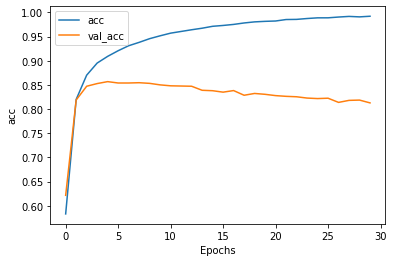

In [16]:
plot_graphs(history, 'acc')


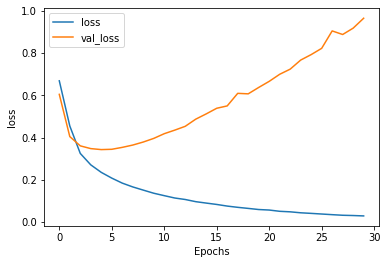

In [17]:
plot_graphs(history, 'loss')

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))